In [1]:
import numpy as np
from pandas import read_csv

# from average_atom.core.average_atom_new import AverageAtom as AA
from average_atom.core.aa_types import AverageAtomFactory
from average_atom.core.misc import jacobi_relaxation, sor
from average_atom.core.grids import NonUniformGrid
from average_atom.core.physics import ThomasFermi, FermiDirac

import matplotlib.pyplot as plt

from hnc.hnc.constants import *
from hnc.hnc.misc import rs_from_n, n_from_rs

plt.rcParams.update({'font.size': 10})
plt.rcParams["figure.figsize"] = (5,3.5)
plt.rcParams["figure.dpi"] = 200
plt.rcParams['xtick.labelsize']=14
plt.rcParams.update({'font.size': 12, 'font.family': 'serif'})
plt.rcParams['legend.fontsize'] = 8

color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

ModuleNotFoundError: No module named 'mendeleev'


In [4]:
# Aluminum
name='Al'
Z, A = 13, 27 

ρ_solid = 2.699 #g/cc, the solid density of aluminum 
ρ = ρ_solid#8.1 # g/cc
ni_cc = ρ/(A*amu_to_AU*AU_to_g)
ni_AU = ni_cc*invcc_to_AU
rs = rs_from_n(ni_AU)

R  = 10*rs

Ti_eV = 1 
Te_eV = 1

#

Te_AU = Te_eV*eV_to_AU
Ti_AU = Ti_eV*eV_to_AU


aa_ZJ  = AverageAtomFactory.create_model("ZJ_ISModel", Z, A, Ti_AU, Te_AU, rs, R, name=name, ignore_vxc=False, xc_type='KSDT', Npoints=2000, rmin=1e-4, N_stencil_oneside = 2)

________________________
Generating NPA
T:  0.03674932539796232
Using More TF fit for initial Zstar = 2.495
	Intializing grid
Initializing, True
Initializing
	Creating Integral Equation Solver
Intialized Potentials and Densities
Initialized


In [6]:
# %%time
# aa_ZJ.solve(verbose=True, picard_alpha=0.5)
# aa_ZJ.set_uii_eff()

In [49]:
aa_ZJ.iet.dst_type=2
aa_ZJ.iet.make_k_r_spaces()
aa_ZJ.iet.initialize()

In [53]:
aa_ZJ.Zstar = 2.89
u_k_Y_approx = 4*π*aa_ZJ.Zstar**2/(  (aa_ZJ.iet.k_array/aa_ZJ.rs)**2 + (aa_ZJ.κ/aa_ZJ.rs)**2)
u_r_Y_approx = aa_ZJ.Zstar**2/(aa_ZJ.iet.r_array*aa_ZJ.rs)*np.exp(-aa_ZJ.κ*aa_ZJ.iet.r_array)

In [54]:
aa_ZJ.iet.dst_type=4
aa_ZJ.iet.make_k_r_spaces()
aa_ZJ.iet.initialize()

u_r_Y_approx_FFT = aa_ZJ.iet.FT_k_2_r(u_k_Y_approx/rs**3)

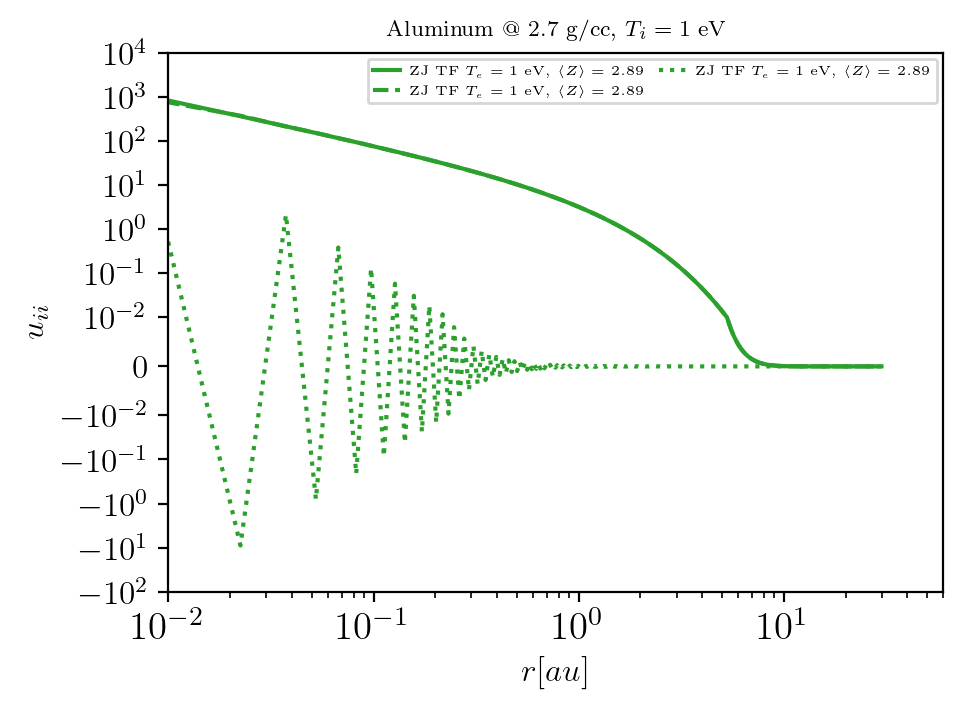

In [55]:
def plot_uii(uii_data, figax = None, **kwargs):#line = None, color=None, label=None):
    if figax is None:
        fig, ax = plt.subplots()
    else:
        fig, ax  = figax
    
    ax.plot(uii_data[0], uii_data[1], **kwargs )#, linestyle=line, color=color, label=label)
    
    ax.set_xlim(1e-2,60)
    ax.set_ylim(-1e2,1e4)
    ax.set_yscale('symlog', linthresh=1e-2)
    ax.set_xscale('log')
    
    ax.set_ylabel(r"$u_{ii}$")
    ax.set_xlabel(r"$r [au]$")
    
    ax.legend(fontsize=4.8, ncols=2, labelspacing=0.5, columnspacing=1)

def load_NS_u_data(filename, fix_factor=1):
    NS_aa = read_csv(filename, skiprows=8, delim_whitespace=True, names=["r", "uii","dvdr"])
    return NS_aa.r, NS_aa.uii*fix_factor
NS_folder = "/home/zach/plasma/average_atom/data/aluminum_2T/aluminum_2T_NS/"

# Fixed Ti cases
NS_tf_u11 = load_NS_u_data(NS_folder + "qm_ksdt_aluminum_ti1ev_t1ev_d2.7gpcc/tf_potential_for_md.jerome.dat")
NS_ks_u11 = load_NS_u_data(NS_folder + "qm_ksdt_aluminum_ti1ev_t1ev_d2.7gpcc/qm_potential_for_md.jerome.dat")

# Fixed Ti
fig, ax = plt.subplots()
ax.set_title(r"Aluminum @ $2.7$ g/cc, $T_i = 1 $ eV", fontsize=8)

# plot_uii(NS_ks_u11, figax = (fig, ax), color=color_cycle[0], linestyle=':', label=r"NS QM $T_e=1$ eV (<Z>=3.00)")
# plot_uii(NS_tf_u11, figax = (fig, ax), color=color_cycle[0], linestyle='--', label=r"NS TF $T_e=1$ eV (<Z>=2.89)")
# plot_uii([NS_tf_u11[0], 2.89**2/NS_tf_u11[0]], figax = (fig, ax), color=color_cycle[1], linestyle='-', label=r"Coulomb (Z=2.89)")

plot_uii(np.array([aa_ZJ.iet.r_array*rs, u_r_Y_approx]), figax = (fig, ax), color=color_cycle[2], linestyle='-',
         label=r"ZJ TF $T_e=1$ eV, $\langle Z \rangle ={0:0.2f}$".format(aa_ZJ.Zstar))

plot_uii(np.array([aa_ZJ.iet.r_array*rs, u_r_Y_approx_FFT]), figax = (fig, ax), color=color_cycle[2], linestyle='--',
         label=r"ZJ TF $T_e=1$ eV, $\langle Z \rangle ={0:0.2f}$".format(aa_ZJ.Zstar))

plot_uii(np.array([aa_ZJ.iet.r_array*rs, u_r_Y_approx-u_r_Y_approx_FFT]), figax = (fig, ax), color=color_cycle[2], linestyle=':',
         label=r"ZJ TF $T_e=1$ eV, $\langle Z \rangle ={0:0.2f}$".format(aa_ZJ.Zstar))